In [ ]:
%pip install shap joblib nltk requests bs4 ipywidgets xgboost pandas numpy seaborn scikit-learn psycopg2-binary

In [1]:
import ipywidgets as widgets
from IPython.display import display

# Create input widget
link_input = widgets.Text(
    placeholder='Enter article link',
    description='Link:',
)

# Create a button widget
fetch_button = widgets.Button(
    description='Fetch Article',
)

# Create a variable to store the link
article_link = None

# Define a function to save the link to the variable
def save_article_link(b):
    global article_link
    article_link = link_input.value

# Attach the function to the button click event
fetch_button.on_click(save_article_link)

# Display the widgets
display(link_input, fetch_button)


Text(value='', description='Link:', placeholder='Enter article link')

Button(description='Fetch Article', style=ButtonStyle())

In [19]:
import requests
from bs4 import BeautifulSoup

# Define a function to fetch and process the article
def fetch_and_process_article():
    # Check if the article link has been provided
    if article_link is None:
        print("Please enter the article link and click 'Fetch Article' in the previous cell.")
        return
    
    try:
        # Fetch the article
        response = requests.get(article_link)
        soup = BeautifulSoup(response.text, "html.parser")
        
        # Find the title
        title_element = soup.find("h1")
        title = title_element.text if title_element else "Title not found"
        
        # Find the text content
        content_element = soup.find("p")
        text = content_element.text if content_element else "Text not found"
        
        # Display the results
        print(f"Title: {title}")
        print(f"Text: {text}")
    except Exception as e:
        print(f"Error: {e}")

# Call the function to fetch and process the article
fetch_and_process_article()


Title: Obesity Study Finds 36% Of Americans One Deep Breath Away From Pants Popping Open
Text: ATLANTA—Referring to the prevalence of the condition in the United States as both widespread and dire, a new obesity study released Wednesday by the Centers for Disease Control found that 36% of Americans were one deep breath away from their pants popping open. “Our data shows that for more than a third of the population, a single, large inhalation is all that would be required for the button to go flying off their pants and their paunch to come flopping out,” said CDC director Dr. Mandy Cohen, adding that certain genetic and socioeconomic circumstances could greatly increase the chance of someone’s pants busting open with a “doink” sound, resulting in their big belly pouring out over their waistline. “In addition, for nearly 120 million Americans, one single bend forward will, at some point in their lifetime, result in their pants splitting up the back and their ass spilling out right there 

[02:34:24] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


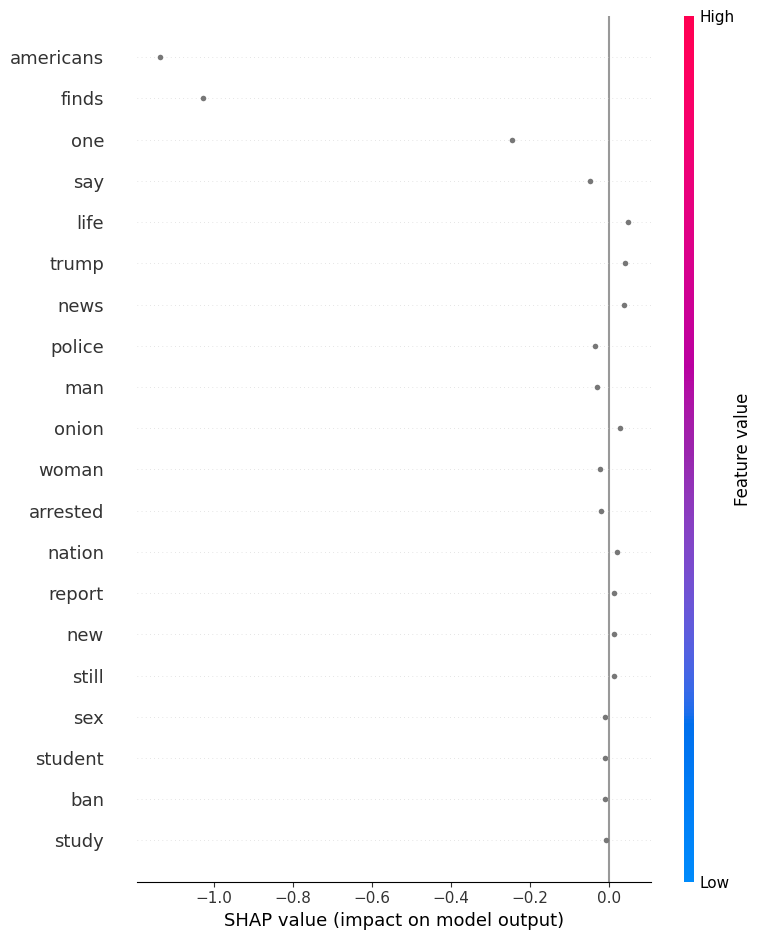

The article is classified as FAKE with confidence score: 7.86%


In [20]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import joblib
import xgboost
from sklearn.feature_extraction.text import TfidfVectorizer
import shap  # Add the SHAP library

# Fetch and process the article
def fetch_article(article_link):
    try:
        # Fetch the article
        response = requests.get(article_link)
        soup = BeautifulSoup(response.text, "html.parser")

        # Find the title
        title_element = soup.find("h1")
        title = title_element.text if title_element else "Title not found"

        return title
    except Exception as e:
        print(f"Error: {e}")
        return None, None

# Preprocess text using NLTK
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a single string
    preprocessed_text = " ".join(tokens)

    return preprocessed_text

# Load the saved vectorizer
vectorizer = joblib.load("onion_vectorizer.pkl")

# Load classifier
classifier = joblib.load("onion_xgboost_classifier.pkl")

# Create a SHAP explainer
explainer = shap.Explainer(classifier)

def classify_article(article_link, classifier):
    title = fetch_article(article_link)
    
    if title is not None:
        
        # Preprocess the article text
        preprocessed_article = preprocess_text(title)
        
        # Transform the input data using the same vectorizer
        input_tfidf = vectorizer.transform([preprocessed_article])
        
        # Predict using the classifier and get probability estimates
        prediction = classifier.predict(input_tfidf)
        probability = classifier.predict_proba(input_tfidf)
        
        # Convert the probability to a percentage
        confidence_percentage = probability[0][1] * 100
        
        # Output the prediction (0 for fake, 1 for real) along with confidence score as a percentage
        if prediction[0] == 0:
            result = f"The article is classified as FAKE with confidence score: {confidence_percentage:.2f}%"
        else:
            result = f"The article is classified as REAL with confidence score: {confidence_percentage:.2f}%"
        
        # Explain the prediction using SHAP values
        explanation = explainer.shap_values(input_tfidf)
        
        # Visualize feature contributions (you can customize this part)
        shap.summary_plot(explanation, input_tfidf, feature_names=vectorizer.get_feature_names_out())
        
        return result
    else:
        return "Article processing failed."

# Example usage
result = classify_article(article_link, classifier)
print(result)
